## Predizendo o IBOV com GP-ARX

Realizar predições no mercado financeiro é um desafio encarado tanto pela indústria quanto pela academia. O aspecto altamente estocástico do problema é um verdadeiro desafio. Existem algumas abordagens para lidar com essa encrenca, alguns deles são: **ARCH**, **GARCH**, **Redes Neurais Recorrentes**, **Redes Neurais Convolucionais**, **ARIMA**, **Métodos Bayesianos** e, inclusive, combinações destes métodos (**Ensemble Learning**).

Neste trabalho vamos analisar o resultado de uma abordagem, encontrada em [Gonzalvez, 2019], que utiliza um método Bayesiano e um método autoregressivo, o modelo **GP-ARX**.ARX significa *Autoregressive with Exogenous* e GP significa *Gaussian Process*. 

### ARX

Um modelo AR é chamado de modelo autoregressivo. Esse tipo de modelo parte da premissa que o passado prediz o futuro. Basicamente, ele pressupõe que uma o valor no tempo $t$, em uma série temporal, é uma função dos valores da série em "tempos" anteriores. Matematicamente, um processo AR que dependa dos $p$ valores mais recentes pode ser escrita como

$$
    Y_{t} = \phi_{0} + \phi_{1} Y_{t-1} + \phi_{2} Y_{t-2} + ... + \phi_{p} Y_{t-p} + \epsilon_{t}.
$$

Aqui, os $\phi$ são os coeficientes da autoregrassão e o termo $\epsilon_{t}$ é um termo de erro Gaussiano associado ao processo. Escolher esses parâmetros são um estudo à parte.

Podemos então inserir variáveis **exógenas**, $u_{t}$, que não são parte da série temporal principal, mas que são consideradas na modelagem para capturar influências externas. Escrevendo a série temporal em termos das variáveis exógenas ficamos com

$$
    Y_{t} = \beta_{0} + \beta_{1} u_{t-1} + \beta_{2} u_{t-2} + ... + \beta_{p} u_{t-q} + \epsilon_{t}.
$$

Combinando essas duas séries, chegamos no modelo ARX(p,q):

$$
    Y_{t, ARX} = \phi_{0} + \phi_{1} Y_{t-1} + \phi_{2} Y_{t-2} + ... + \phi_{p} Y_{t-p} +\beta_{0} + \beta_{1} u_{t-1} + \beta_{2} u_{t-2} + ... + \beta_{p} u_{t-q}+ \epsilon_{t}.
$$

Novamente, determinar a dupla $(p, \ q)$ é um estudo à parte.

### Processos Gaussianos

Um Processo Gaussiano **é uma ferramenta de machine learning que pode ser utilizada para reconstruir, de maneira não paramétrica, uma função que descreva um conjunto de dados**. De maneira um pouco mais aprofundada, esse instrumento utiliza **inferência Bayesiana para construir uma distribuição multivariada no espaço de funções**.

Para realizar a regressão (ou reconstrução), o processo necessita de algumas coisas:
* Dados de entrada, $(X, Y)$;
* Um _ansatz_ para função média que descreva os dados, $\mu (x)$;
* Uma função de covariância, também chamada de kernel, $k(x, \bar{x})$.

A função $k(x, \bar{x})$ depende, por sua vez, de alguns hiperparâmetros que variam dependendo da escolha da função. Neste trabalho, vamos utilizar a função _RBF_:

$$
k(x, \bar{x}) = \exp\left(-\frac{\|x - \bar{x}\|^2}{2\sigma^2}\right).
$$

Essa função depende dos hiperparâmetros $\sigma$ e $l$.

Dessa forma, podemos descrever nossos dados como:

$$
f(x) \sim \mathcal{GP}(\mu(x), \ k(x, \ \bar{x})).
$$

Adentrando um pouco mais na matemática, nosso problema se resume (para mais detalhes vide as referências) a calcular

 $$p(f^{*}|y) = \frac{p(y,f^{*})}{p(y)}$$
$$=\frac{1}{(2\pi)^{n^{*}/2}\sqrt{det(A)}} exp\left( -\frac{1}{2} [(f^{*}-\bar{f^{*}})^{T} cov(f^{*})^{-1} (f^{*}-\bar{f^{*}})\right)$$ 
$$= \mathcal{N}(\bar{f^{*}}, cov(f^{*})),$$

onde
    $$\bar{f^{*}} = \mu^{*}+K^{*T}\bar{K}^{-1}(y-\mu)$$
e
    $$cov(f^{*}) = K^{**}-K^{*T}\bar{K}^{-1}K^{*}$$.

Vemos então a dependência que a função média da nossa reconstrução, $\bar{f^{*}}$, tem da função média *prior*, $\mu$. Ou seja, o valor de $\mu$ influencia diretamente nossa reconstrução.

### GP-ARX

Então, a grosso modo, o modelo GP-ARX pode ser escrito como

$$
Y_{t} = f(X_{t}) + \epsilon_{t}
$$

onde o vetor de entrada $X_{t}$ pode conter tanto as variáveis autorregressivas quanto as variáveis exógenas e $f(x)$ é uma função não-linear modelada por um Processo Gaussiano.

### Principais Referências
1. [Gonzalvez, 2019] Joan Gonzalvez & Edmond Lezmi & Thierry Roncalli & Jiali Xu, 2019. **Financial Applications of Gaussian Processes and Bayesian Optimization**. Papers 1903.04841, arXiv.org.
2021


In [43]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt, savetxt
import random
from typing import List, Tuple
import pandas as pd
from datetime import datetime
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import LinearRegression

### Obtendo os Dados

In [44]:
start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
ibov_data = yf.download('^BVSP', start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed


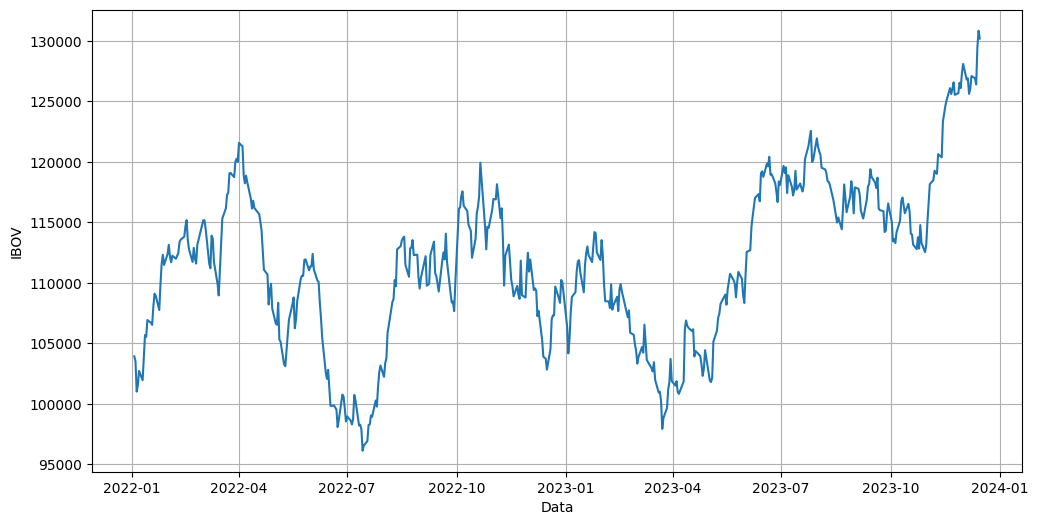

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(ibov_data)
plt.xlabel('Data')
plt.ylabel('IBOV')
plt.grid(True)
plt.show()

Também vamos preciar da série de retornos

In [46]:
ibov_returns = ibov_data.pct_change().dropna()

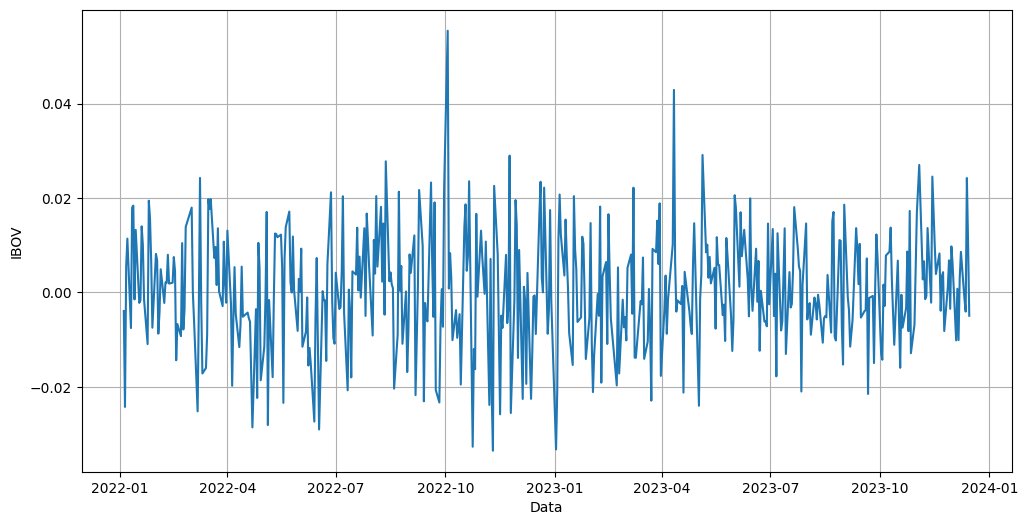

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(ibov_returns)
plt.xlabel('Data')
plt.ylabel('IBOV')
plt.grid(True)
plt.show()

Perfeito. Vamos começar aplicando o processo à série de preços.

### Predizendo a série de preços

Vamos começar dividindo nossa base em treino e teste

In [48]:
data = pd.DataFrame({'IBOV': ibov_data, 'IBOV_Lag1': ibov_data.shift(1)})

data = data.dropna()

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

y_train, X_train = train['IBOV'], train[['IBOV_Lag1']]
y_test, X_test = test['IBOV'], test[['IBOV_Lag1']]

Vamos ajustar nosso modelo ARX

In [49]:
arx_model = LinearRegression()
arx_model.fit(X_train, y_train)
predictions_arx = arx_model.predict(X_test)

E aqui vamos ajustar nosso processo Gaussiano aos resíduos do nosso treinamento

In [50]:
residuals = y_train - arx_model.predict(X_train)
residuals = residuals.values.reshape(-1, 1)
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_model.fit(X_train, residuals)

/home/victor/.local/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [51]:
residuals_pred, _ = gp_model.predict(X_test, return_std=True)

Adicionamos a previsão dos nossos resíduos ao nosso ARX

In [52]:
predictions_gparx = arx_model.predict(X_test) + residuals_pred.flatten()

Avaliamos a eficácia do nosso modelo

In [53]:
mse_arx = np.mean((predictions_arx - y_test)**2)
mse_gparx = np.mean((predictions_gparx - y_test)**2)

print(f'Mean Squared Error (MSE) - ARX: {mse_arx}')
print(f'Mean Squared Error (MSE) - GP-ARX: {mse_gparx}')

rmse_arx = np.sqrt(mse_arx)
rmse_gparx = np.sqrt(mse_gparx)

print(f'RMSE - ARX: {rmse_arx}')
print(f'RMSE - GP-ARX: {rmse_gparx}')

Mean Squared Error (MSE) - ARX: 1430315.3396780498
Mean Squared Error (MSE) - GP-ARX: 1438514.9554633587
RMSE - ARX: 1195.9579171852367
RMSE - GP-ARX: 1199.3810718296995


Observamos que o erro da nossa predição é muito pequeno e a diferença ao utilizar somente o ARX e utilizar o GP-ARX é ínfima.

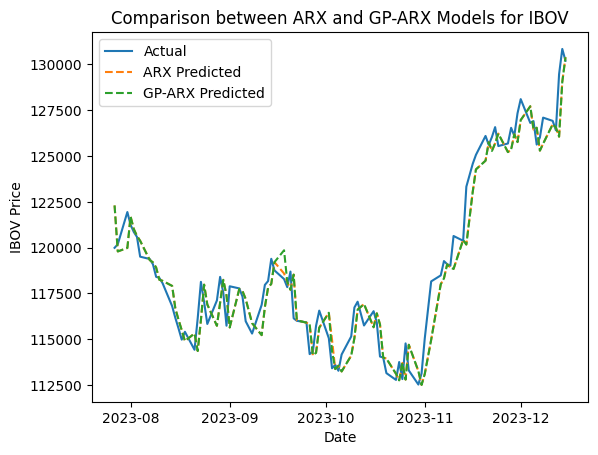

In [54]:
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, predictions_arx, label='ARX Predicted', linestyle='--')
plt.plot(test.index, predictions_gparx, label='GP-ARX Predicted', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('IBOV Price')
plt.title('Comparison between ARX and GP-ARX Models for IBOV')
plt.show()

Vamos trabalhar agora em algo um pouco mais dificil, a série de retornos.

### Predizendo a série de Retornos

In [55]:
data = pd.DataFrame({'IBOV_Returns': ibov_returns, 'IBOV_Returns_Lag1': ibov_returns.shift(1)})
data = data.dropna()

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

y_train, X_train = train['IBOV_Returns'], train[['IBOV_Returns_Lag1']]
y_test, X_test = test['IBOV_Returns'], test[['IBOV_Returns_Lag1']]

In [56]:
arx_model = LinearRegression()
arx_model.fit(X_train, y_train)
returns_predictions_arx = arx_model.predict(X_test)

In [57]:
residuals = y_train - arx_model.predict(X_train)
residuals = residuals.values.reshape(-1, 1)  # Reshape para um array 2D
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_model.fit(X_train, residuals)

/home/victor/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/victor/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [58]:
residuals_pred, _ = gp_model.predict(X_test, return_std=True)
returns_predictions_gparx = arx_model.predict(X_test) + residuals_pred.flatten()

In [59]:
mse_arx = np.mean((predictions_arx - y_test)**2)
mse_gparx = np.mean((predictions_gparx - y_test)**2)

print(f'Mean Squared Error (MSE) - ARX: {mse_arx}')
print(f'Mean Squared Error (MSE) - GP-ARX: {mse_gparx}')

rmse_arx = np.sqrt(mse_arx)
rmse_gparx = np.sqrt(mse_gparx)

print(f'RMSE - ARX: {rmse_arx}')
print(f'RMSE - GP-ARX: {rmse_gparx}')

Mean Squared Error (MSE) - ARX: 14140968409.278221
Mean Squared Error (MSE) - GP-ARX: 14142573898.78511
RMSE - ARX: 118915.80386676206
RMSE - GP-ARX: 118922.5542056052


Aqui observamos que o erro da nossa predição é extremamente alto.

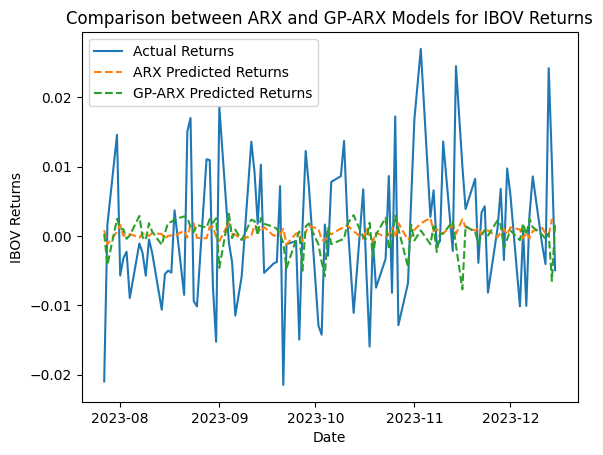

In [60]:
plt.plot(test.index, y_test, label='Actual Returns')
plt.plot(test.index, returns_predictions_arx, label='ARX Predicted Returns', linestyle='--')
plt.plot(test.index, returns_predictions_gparx, label='GP-ARX Predicted Returns', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('IBOV Returns')
plt.title('Comparison between ARX and GP-ARX Models for IBOV Returns')
plt.show()

Conseguimos predizer bem a série de preços, mas falhamos na série de retornos. Isso pois a segunda abordagem é mais complicada. Predizer o preço é um tanto mais fácil, uma abordagem, por exemplo, é supor que o preço de amanhã é o preço de hoje somado com algum R$1. Mas vimos que esse processo pode ser bastante promissor